In [56]:
import pandas as pd
import numpy as np
import random

def data_split(df, seed, stayid, mode):

    ## patientunitstayid를 기준으로 split 진행
    ## Source는 학습에 70%, Target 학습에 30% 사용
    random.seed(seed)

    all_list = df[stayid].unique().tolist()

    if mode.startswith('s'): 
        sample_size = int(len(all_list) * 0.7)
    else:
        sample_size = int(len(all_list) * 0.3)
    
    train_unitid = random.sample(all_list,sample_size)
    df_train, df_valid  = df.query('@train_unitid in ' + stayid), df.query('@train_unitid not in ' + stayid)

    return df_train, df_valid

source = pd.read_csv('./Data/HiRID_ARDS_12H_SPLIT.csv.gz', compression='gzip')
_, source_valid = data_split(source, 42, 'SUBJECT_ID', 's')

target = pd.read_csv('./Data/MIMIC_ARDS_12H_SPLIT.csv.gz', compression='gzip')
_, target_test = data_split(target, 42, 'SUBJECT_ID', 't')

# classification result

DA_source_result = pd.read_csv('./result_best/hirid_mimic_all/DA_Source_valid_result.csv')
DA_target_result = pd.read_csv('./result_best/hirid_mimic_all/DA_Target_test_result.csv')

DA_source_feature = pd.read_csv('./result_best/hirid_mimic_all/DA_Source_valid_feature.csv')
DA_target_feature = pd.read_csv('./result_best/hirid_mimic_all/DA_Target_test_feature.csv')

# feature space of transformer

NDA_source_result = pd.read_csv('./result_best/hirid_mimic_uni_all/NDA_Source_valid_result.csv')
NDA_target_result = pd.read_csv('./result_best/hirid_mimic_uni_all/NDA_Target_test_result.csv')

NDA_source_feature = pd.read_csv('./result_best/hirid_mimic_uni_all/NDA_Source_valid_feature.csv')
NDA_target_feature = pd.read_csv('./result_best/hirid_mimic_uni_all/NDA_Target_test_feature.csv')

# last layer of clf hidden space

DA_source_clf = pd.read_csv('./result_best/source_udart_classifier_feature_vector.csv')
DA_target_clf = pd.read_csv('./result_best/target_udart_classifier_feature_vector.csv')

NDA_source_clf = pd.read_csv('./result_best/source_uni_classifier_feature_vector.csv')
NDA_target_clf = pd.read_csv('./result_best/target_uni_classifier_feature_vector.csv')

if (len(DA_source_result) == len(DA_source_feature) == len(NDA_source_result)):
    print('source 문제 없음')
else:
    print('matching 실패')
    
if (len(DA_target_result) == len(DA_target_feature) == len(NDA_target_result)):
    print('target 문제 없음')
else:
    print('matching 실패')

source 문제 없음
target 문제 없음


In [50]:
hirid = pd.read_csv('/Users/DAHS/Desktop/uDART/Data/HIRID_ARDS_12H.csv.gz')
mimic = pd.read_csv('/Users/DAHS/Desktop/uDART/Data/MIMIC_ARDS_12H.csv.gz')

In [65]:
def count(df, valid):
    print('총 환자 수: ', df.SUBJECT_ID.nunique())
    print('총 관측치 수: ', len(df))
    print('Annotation 비율: ', df.Annotation.value_counts(normalize=True))
    print('클래스 비율: ', valid.ARDS_next_12h.value_counts(normalize=True))

In [66]:
count(hirid, eval_set_DA_S)

총 환자 수:  10775
총 관측치 수:  1200844
Annotation 비율:  Annotation
Not ARDS    0.688342
ARDS        0.311658
Name: proportion, dtype: float64
클래스 비율:  ARDS_next_12h
0.0    0.852701
1.0    0.147299
Name: proportion, dtype: float64


In [67]:
count(mimic, eval_set_DA_T)

총 환자 수:  3736
총 관측치 수:  488414
Annotation 비율:  Annotation
Not ARDS    0.93252
ARDS        0.06748
Name: proportion, dtype: float64
클래스 비율:  ARDS_next_12h
0.0    0.713436
1.0    0.286564
Name: proportion, dtype: float64


In [59]:
eval_set_DA_S.ARDS_next_12h.value_counts(normalize=True)

ARDS_next_12h
0.0    0.852701
1.0    0.147299
Name: proportion, dtype: float64

In [60]:
eval_set_DA_T.ARDS_next_12h.value_counts(normalize=True)

ARDS_next_12h
0.0    0.713436
1.0    0.286564
Name: proportion, dtype: float64

In [57]:
eval_set_DA_S = pd.concat([source_valid.reset_index(drop=True), DA_source_result], axis = 1)
eval_set_DA_T = pd.concat([target_test.reset_index(drop=True), DA_target_result], axis = 1)

eval_set_NDA_S = pd.concat([source_valid.reset_index(drop=True), NDA_source_result], axis = 1)
eval_set_NDA_T = pd.concat([target_test.reset_index(drop=True), NDA_target_result], axis = 1)

eval_set_DA_S.isnull().sum().sum() + eval_set_DA_T.isnull().sum().sum() + eval_set_NDA_S.isnull().sum().sum() + eval_set_NDA_T.isnull().sum().sum()

0

In [289]:
eval_set_DA_S['Pred'] = np.where(eval_set_DA_S['Positive_Confscore'] >= 0.5, 1, 0)
positive = eval_set_DA_S[eval_set_DA_S['ARDS_next_12h'] == eval_set_DA_S['Pred']]
attn_positive = positive[positive['ARDS_next_12h']==1]
attn_positive[['SUBJECT_ID', 'Time_since_ICU_admission']].to_csv('attention_positive_patient.csv', index=False)

In [313]:
# Accuracy, AUROC, event recall, precison, MMD

from tqdm import tqdm
from sklearn.metrics import precision_score, auc, accuracy_score, roc_auc_score, f1_score
pd.set_option('mode.chained_assignment',  None)
import warnings
warnings.simplefilter('ignore')

def precision_recall_th(target_test, threshold):

    df = target_test.copy() 

    interest = df[['SUBJECT_ID', 'Time_since_ICU_admission', 'Annotation', 'ARDS_next_12h', 'Positive_Confscore']]
    interest['Pred'] = np.where(interest['Positive_Confscore'] > threshold, 1, 0)

    precisionset = interest[~(interest['Annotation']=='ARDS')]
    precision = precision_score(precisionset.ARDS_next_12h, precisionset.Pred, average='macro')

    captured_event = 0
    total_event = len(interest[interest['Annotation']=='ARDS'])

    for stayid in interest.SUBJECT_ID.unique():
        current_view = interest[interest['SUBJECT_ID']==stayid]
        if any(current_view['Annotation']=='ARDS') == True:
            
            prediction_window = current_view.iloc[-13:-1, :]
            
            if prediction_window['Pred'].sum() >= 1:
                captured_event += 1
            
        else:
            pass
    try:    
        
        recall = np.round(captured_event / total_event, 4)
    except:
        recall = 0
        
    return precision, recall


def eval(df, th):
    data = df.copy()
    precision, recall = precision_recall_th(data, th)
    data['Pred'] = np.where(data['Positive_Confscore'] > th, 1, 0)
    accuracy = accuracy_score(data.ARDS_next_12h, data.Pred)
    rocauc = roc_auc_score(data.ARDS_next_12h, data.Pred, average='macro')
    f1 = 2*(precision*recall) / (precision + recall)
    
    result = pd.DataFrame([{'ACC':accuracy, 'AUROC':rocauc, 'Recall':recall, 'Precision':precision, 'F1-Score':f1}])
    return result


def eval_for_closest_precisions(df):
    thresholds = [0.01 * i for i in range(1, 100)]
    results = []
    for th in thresholds:
        res = eval(df, th)
        res['Threshold'] = th
        results.append(res)
    df_results = pd.concat(results)
    df_results['AUPRC'] = auc(df_results['Recall'].values, df_results['Precision'].values)
    # display(df_results)
    return df_results

DA_s_val = eval_for_closest_precisions(eval_set_DA_S)
NDA_s_val = eval_for_closest_precisions(eval_set_NDA_S)

DA_t_tst = eval_for_closest_precisions(eval_set_DA_T)
NDA_t_tst = eval_for_closest_precisions(eval_set_NDA_T)

In [314]:
# Source validation 평가에서는 두 버전 간 큰 차이가 없었음(DA를 한 버전의 성능이 약간 감소)

display(DA_s_val[DA_s_val['Threshold']==0.5])

#하지만 Target에서는 두 버전 간 큰 차이가 벌어짐. DA를 했을 때는 source에서의 성능을 유지하거나 오히려 상승했지만 DA를 안했을 때는 매우 큰 일반화 오류를 보였음(특히 recall)

display(NDA_s_val[NDA_s_val['Threshold']==0.5])

display(DA_t_tst[DA_t_tst['Threshold']==0.5])

display(NDA_t_tst[NDA_t_tst['Threshold']==0.5])

,ACC,AUROC,Recall,Precision,F1-Score,Threshold,AUPRC
0,0.599467,0.701651,0.9616,0.591133,0.732171,0.5,0.56835


,ACC,AUROC,Recall,Precision,F1-Score,Threshold,AUPRC
0,0.618546,0.697322,0.9463,0.588526,0.725714,0.5,0.567781


,ACC,AUROC,Recall,Precision,F1-Score,Threshold,AUPRC
0,0.607985,0.630743,0.9236,0.602629,0.729364,0.5,0.558192


,ACC,AUROC,Recall,Precision,F1-Score,Threshold,AUPRC
0,0.587141,0.570753,0.6561,0.55125,0.599122,0.5,0.563019


In [311]:
eval_set_NDA_S['Pred'] = np.where(eval_set_NDA_S['Positive_Confscore'] > 0.5, 1, 0)
eval_set_DA_T['Pred'] = np.where(eval_set_DA_T['Positive_Confscore'] > 0.5, 1, 0)
eval_set_NDA_T['Pred'] = np.where(eval_set_NDA_T['Positive_Confscore'] > 0.5, 1, 0)

In [312]:
print(recall_score(eval_set_DA_S.ARDS_next_12h, eval_set_DA_S.Pred))
print(recall_score(eval_set_NDA_S.ARDS_next_12h, eval_set_NDA_S.Pred))
print(recall_score(eval_set_DA_T.ARDS_next_12h, eval_set_DA_T.Pred))
print(recall_score(eval_set_NDA_T.ARDS_next_12h, eval_set_NDA_T.Pred))

0.8465096719932717
0.8089991589571068
0.6840553704178416
0.5323634965393489


In [243]:
### MMD (Maximum Mean Discrepancy)
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.
import numpy as np
from sklearn import metrics


def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [244]:
# MMD 성능
import random
random.seed(42)

MMD_NDA_s = NDA_source_feature.copy()
MMD_DA_s = DA_source_feature.copy()


MMD_NDA_t = NDA_target_feature.copy()
MMD_DA_t = DA_target_feature.copy()


### HIRID vs MIMIC
print('After DA')
print(f' MMD Lienar Value : {mmd_linear(MMD_DA_s.sample(n = 30000, random_state = 42), MMD_DA_t.sample(n = 30000, random_state = 42))}') 
print(f' MMD RBF Value : {mmd_rbf(MMD_DA_s.sample(n = 30000, random_state = 42), MMD_DA_t.sample(n = 30000, random_state = 42))}') 
print(f' MMD Poly Value : {mmd_poly(MMD_DA_s.sample(n = 30000, random_state = 42), MMD_DA_t.sample(n = 30000, random_state = 42))}') 

print('Before DA')
print(f' MMD Lienar Value : {mmd_linear(MMD_NDA_s.sample(n = 30000, random_state = 42), MMD_NDA_t.sample(n = 30000, random_state = 42))}') 
print(f' MMD RBF Value : {mmd_rbf(MMD_NDA_s.sample(n = 30000, random_state = 42), MMD_NDA_t.sample(n = 30000, random_state = 42))}')  
print(f' MMD Poly Value : {mmd_poly(MMD_NDA_s.sample(n = 30000, random_state = 42), MMD_NDA_t.sample(n = 30000, random_state = 42))}') 

After DA
 MMD Lienar Value : 5.093860863876056
 MMD RBF Value : 0.0007328762084609639
 MMD Poly Value : 3476.792478763149
Before DA
 MMD Lienar Value : 1.0691806994964186
 MMD RBF Value : 0.00300996346541643
 MMD Poly Value : 485.142369991383


In [ ]:
### HIRID vs MIMIC
print('After DA')
print(f' MMD Lienar Value : {mmd_linear(MMD_DA_s.sample(n = 30000, random_state = 42), MMD_DA_t.sample(n = 30000, random_state = 42))}') 
print(f' MMD RBF Value : {mmd_rbf(MMD_DA_s.sample(n = 30000, random_state = 42), MMD_DA_t.sample(n = 30000, random_state = 42))}') 
print(f' MMD Poly Value : {mmd_poly(MMD_DA_s.sample(n = 30000, random_state = 42), MMD_DA_t.sample(n = 30000, random_state = 42))}') 

print('Before DA')
print(f' MMD Lienar Value : {mmd_linear(MMD_NDA_s.sample(n = 30000, random_state = 42), MMD_NDA_t.sample(n = 30000, random_state = 42))}') 
print(f' MMD RBF Value : {mmd_rbf(MMD_NDA_s.sample(n = 30000, random_state = 42), MMD_NDA_t.sample(n = 30000, random_state = 42))}')  
print(f' MMD Poly Value : {mmd_poly(MMD_NDA_s.sample(n = 30000, random_state = 42), MMD_NDA_t.sample(n = 30000, random_state = 42))}') 

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA 시각화

MMD_NDA_s = NDA_source_feature.copy()
MMD_DA_s = DA_source_feature.copy()

MMD_NDA_t = NDA_target_feature.copy()
MMD_DA_t = DA_target_feature.copy()

# source arrangement

MMD_DA_s['ARDS_next_12h'] = source_valid.ARDS_next_12h.values
MMD_NDA_s['ARDS_next_12h'] = source_valid.ARDS_next_12h.values

# sampling

a = MMD_DA_s[MMD_DA_s['ARDS_next_12h']==1].sample(n=1000, random_state=42)
b = MMD_DA_s[MMD_DA_s['ARDS_next_12h']==0].sample(n=3000, random_state=42)

vis_set_s_da = pd.concat([a, b], axis = 0).sample(frac=1)

a = MMD_NDA_s[MMD_NDA_s['ARDS_next_12h']==1].sample(n=1000, random_state=42)
b = MMD_NDA_s[MMD_NDA_s['ARDS_next_12h']==0].sample(n=3000, random_state=42)

vis_set_s_nda = pd.concat([a, b], axis = 0).sample(frac=1)


# target arrangement

MMD_DA_t['ARDS_next_12h'] = target_test.ARDS_next_12h.values
MMD_NDA_t['ARDS_next_12h'] = target_test.ARDS_next_12h.values

# sampling

a = MMD_DA_t[MMD_DA_t['ARDS_next_12h']==1].sample(n=1000, random_state=42)
b = MMD_DA_t[MMD_DA_t['ARDS_next_12h']==0].sample(n=3000, random_state=42)

vis_set_t_da = pd.concat([a, b], axis = 0).sample(frac=1)

a = MMD_NDA_t[MMD_NDA_t['ARDS_next_12h']==1].sample(n=1000, random_state=42)
b = MMD_NDA_t[MMD_NDA_t['ARDS_next_12h']==0].sample(n=3000, random_state=42)

vis_set_t_nda = pd.concat([a, b], axis = 0).sample(frac=1)

# Labeling

vis_set_s_da['domain']='source'
vis_set_s_nda['domain']='source'

vis_set_t_da['domain']='target'
vis_set_t_nda['domain']='target'

vis_total_DA = pd.concat([vis_set_s_da, vis_set_t_da], axis = 0).sample(frac=1, random_state=42)
vis_total_NDA = pd.concat([vis_set_s_nda, vis_set_t_nda], axis = 0).sample(frac=1, random_state=42)

# conducting PCA

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(vis_total_DA.drop(['domain', 'ARDS_next_12h'], axis = 1))
PCA_DA = pd.DataFrame(data=printcipalComponents, columns = ['component 0', 'component 1'])

print('Domain Adaptation PCA variation')
print(pca.explained_variance_ratio_)

PCA_DA['domain'] = vis_total_DA.domain.values
PCA_DA['ARDS_next_12h'] = vis_total_DA.ARDS_next_12h.values

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(vis_total_NDA.drop(['domain', 'ARDS_next_12h'], axis = 1))
PCA_NDA = pd.DataFrame(data=printcipalComponents, columns = ['component 0', 'component 1'])

print('Domain Adaptation PCA variation')
print(pca.explained_variance_ratio_)


PCA_NDA['domain'] = vis_total_NDA.domain.values
PCA_NDA['ARDS_next_12h'] = vis_total_NDA.ARDS_next_12h.values

Domain Adaptation PCA variation
[0.8653099 0.0813228]
Domain Adaptation PCA variation
[0.84262287 0.07427749]


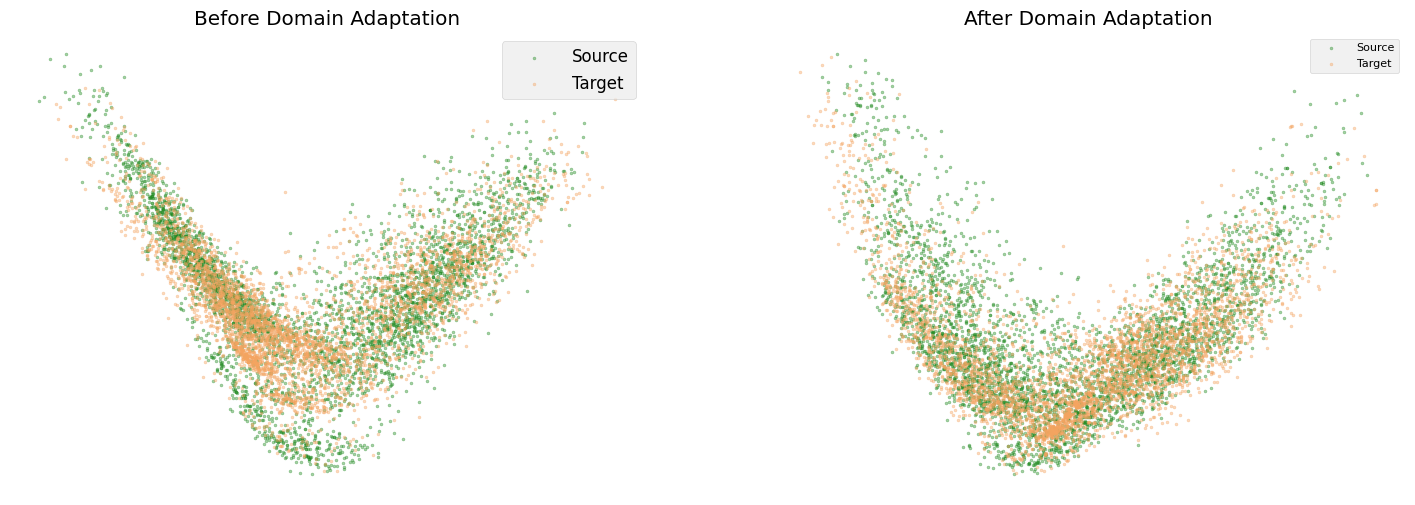

In [49]:
source_DA = PCA_DA[PCA_DA['domain'] == 'source']
target_DA = PCA_DA[PCA_DA['domain'] == 'target']

source_NDA = PCA_NDA[PCA_NDA['domain'] == 'source']
target_NDA = PCA_NDA[PCA_NDA['domain'] == 'target']

# target 별 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the first set of data on the first subplot
axes[0].scatter(source_NDA['component 0'], source_NDA['component 1'], color='forestgreen', label='Source', s=4, alpha=0.4)
axes[0].scatter(target_NDA['component 0'], target_NDA['component 1'], color='sandybrown', label='Target', s=4, alpha=0.4)
axes[0].legend(fontsize=12, handlelength=3)
axes[0].set_title('Before Domain Adaptation')
axes[0].set_xlabel('component 0')
axes[0].set_ylabel('component 1')

# Plotting the second set of data on the second subplot
axes[1].scatter(source_DA['component 0'], source_DA['component 1'], color='forestgreen', label='Source', s=4, alpha=0.4)
axes[1].scatter(target_DA['component 0'], target_DA['component 1'], color='sandybrown', label='Target', s=4, alpha=0.4)
axes[1].legend(fontsize=12, handlelength=3)
axes[1].set_title('After Domain Adaptation')
axes[1].set_xlabel('component 0')
axes[1].set_ylabel('component 1')


axes[0].axis('off')
# axes[0].grid(True)

axes[1].axis('off')
plt.grid(True)


# axes[0].set_xlim(-30, 30)
# axes[1].set_xlim(-40, 50)
# axes[0].set_ylim(-20, 20)
# axes[1].set_ylim(-20, 20)

plt.legend(fontsize=8, handlelength=3)
plt.show()

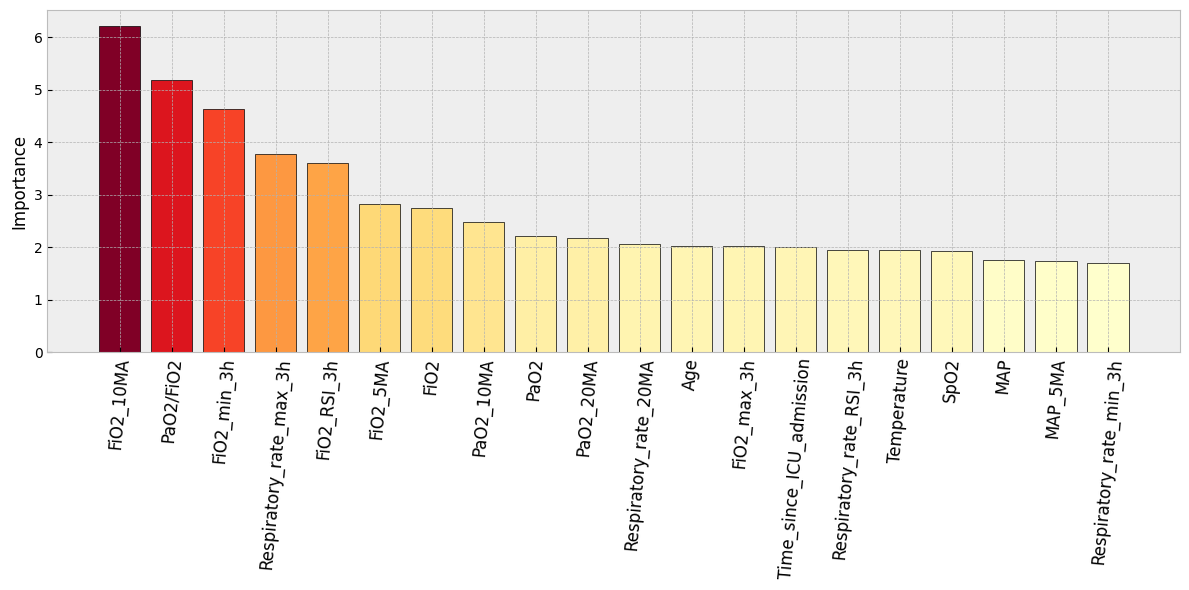

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import data_provider_positive 
from imp import reload
reload(data_provider_positive)


plt.style.use('bmh')

attn = np.load('/Users/DAHS/Desktop/uDART/result_best/hirid_mimic_all/attention_map.npy')

dataset_s_train = data_provider_positive.PositiveDataset(data_path='./Data/HiRID_ARDS_12H_SPLIT.csv.gz', data_type='hirid',mode='s_train',seed=42)

# feature importance

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

heads = 8
layers = 6

columns = ['CLS_Token'] + dataset_s_train.df_cat.columns.tolist() + dataset_s_train.df_num.columns.tolist()
cls = [2.0, 4.0]

valid_indices = [i for i, col in enumerate(columns) if "_fillna" not in col != "CLS_Token"]

ps = []

sample_len = attn.shape[1] 

for sample in range(sample_len):
    get_cls_attentionmap = attn[:, sample, :, 0:1, :]  # (l, h, 1, f), sample에는 for 문의 결과로 1개의 샘플이 들어감 (layer 수, head 수, cls 1개, 컬럼 수)
    sigma = get_cls_attentionmap.sum(axis=0).sum(axis=0) 
    p = sigma / (heads * layers)
    ps.append(p)

p = np.array(ps).sum(axis=0) / sample_len * 100 #scaling

if p.ndim == 2 and p.shape[0] == 1:
    p = p.ravel()

p_filtered = p[valid_indices]
top_feature_indices = np.argsort(p_filtered)[-20:][::-1]
top_p_values = p_filtered[top_feature_indices]
top_feature_names = [columns[valid_indices[i]] for i in top_feature_indices]

cmap = plt.get_cmap('YlOrRd')
norm = plt.Normalize(vmin=min(sorted_p_values), vmax=max(sorted_p_values))
colors = cmap(norm(sorted_p_values))

plt.figure(figsize=(12, 6))  

sorted_indices = np.argsort(top_p_values)[::-1]
sorted_p_values = np.array(top_p_values)[sorted_indices]
sorted_feature_names = np.array(top_feature_names)[sorted_indices]

# 수직 막대 그래프
bars = plt.bar(range(len(sorted_p_values)), sorted_p_values, color=colors, edgecolor='black')

# X축 레이블을 feature names로 설정
plt.xticks(ticks=range(len(sorted_feature_names)), labels=sorted_feature_names, fontsize=12, rotation=85)

plt.ylabel('Importance', fontsize=12)  
plt.tight_layout() 
plt.show()


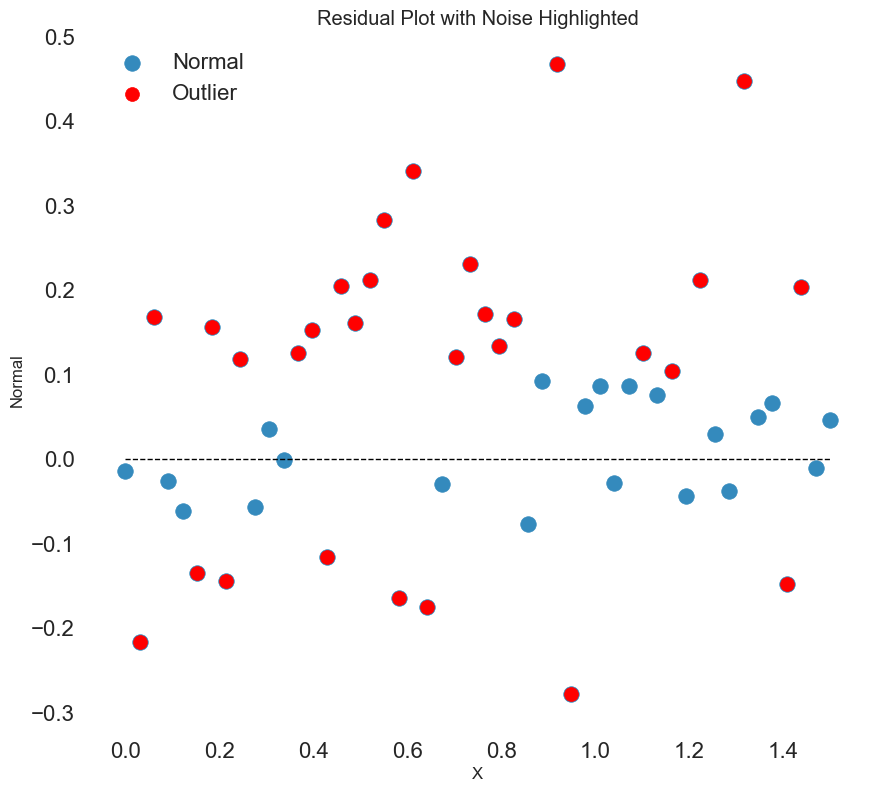

In [332]:
import numpy as np
import matplotlib.pyplot as plt

# 예제 데이터 생성 (이미지를 기반으로 추정)
np.random.seed(22)
x = np.linspace(0, 1.5, 50)
y = 0.7 * x + np.random.normal(0, 0.15, x.size)

# 잔차 계산
residuals = y - (0.6 * x)

# 노이즈 조건 설정 (임의의 기준으로 노이즈를 정의)
noise_threshold = 0.1
noise_indices = np.abs(residuals) > noise_threshold

# 시각화
plt.figure(figsize=(10, 9))

# 잔차 플롯
plt.scatter(x, residuals, label='Normal')
plt.plot(x, np.zeros_like(x), 'k--', linewidth=1)

# 노이즈 강조
plt.scatter(x[noise_indices], residuals[noise_indices], color='red', s=100, label='Outlier')

# 그래프 제목 및 축 레이블 추가
plt.title('Residual Plot with Noise Highlighted')
plt.xlabel('X')
plt.ylabel('Normal')
plt.legend()
plt.gca().set_facecolor('white')  # 배경을 흰색으로 설정
plt.grid(False)  # 격자 제거
plt.show()


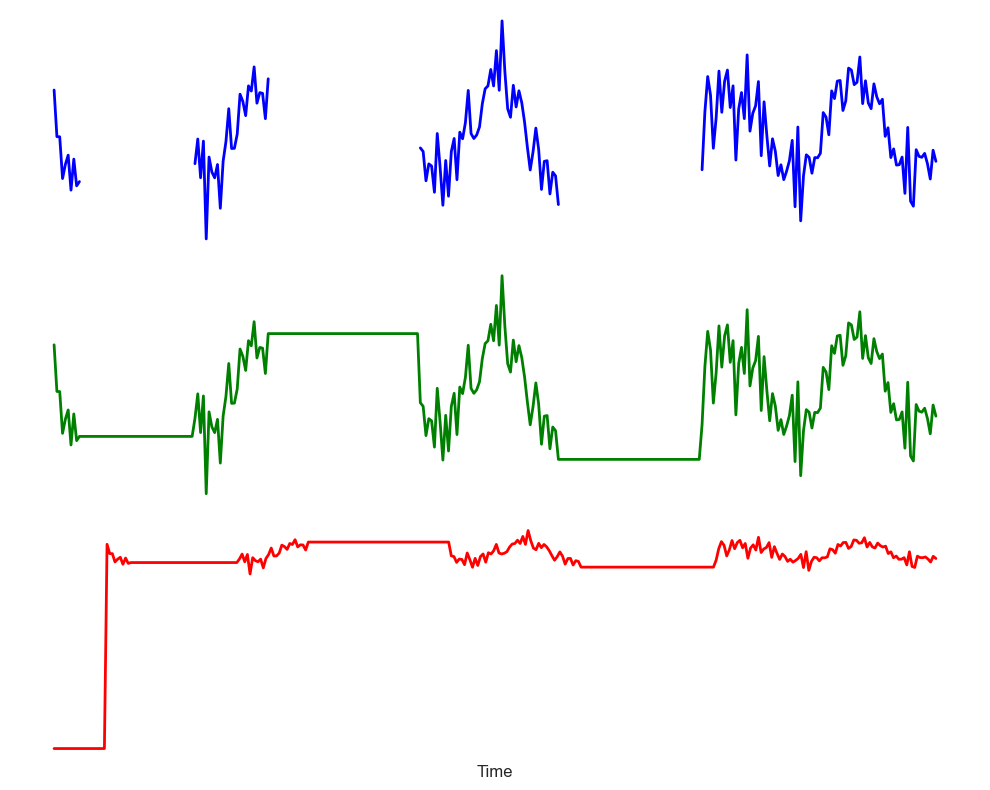

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 예제 데이터 생성
np.random.seed(42)
time = np.arange(0, 100, 0.3)
baseline = 110
amplitude = 10
noise = np.random.normal(0, 5, size=len(time))
vital_sign = baseline + amplitude * np.sin(0.5 * time) + noise
vital_sign[0:20] = np.nan  # 첫 시점부터 결측치 포함
vital_sign[30:70] = np.nan
vital_sign[97:150] = np.nan
vital_sign[200:250] = np.nan

# 첫 번째 그림: 결측치가 있는 원본 데이터
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(time, vital_sign, linestyle='-', color='blue')
# plt.title('Original Data with Missing Values')

# 두 번째 그림: Forward Fill 적용
filled_vital_sign = pd.Series(vital_sign).fillna(method='ffill')
plt.subplot(3, 1, 2)
plt.plot(time, filled_vital_sign, linestyle='-', color='green')

# 세 번째 그림: Forward Fill 후 첫 측정 값 이전 결측치를 -100으로 채움
filled_vital_sign_ffill_bfill = filled_vital_sign.copy()
filled_vital_sign_ffill_bfill[:np.where(~np.isnan(vital_sign))[0][0]] = -100
plt.subplot(3, 1, 3)
plt.plot(time, filled_vital_sign_ffill_bfill, linestyle='-', color='red')
# plt.title('Forward Fill and Fill First Missing with -100')
plt.xlabel('Time')

# 그래프 배경과 격자 설정
for ax in plt.gcf().get_axes():
    ax.set_facecolor('white')  # 배경을 흰색으로 설정
    ax.grid(False)  # 격자 제거
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # 축 값 제거
    # ax.axhline(0, color='black', linewidth=0.5)  # X 축 선 추가
    # ax.axvline(0, color='black', linewidth=0.5)  # Y 축 선 추가

plt.tight_layout()
plt.show()
